## Localizer of the source time series
On all the subjects from the experiment of Bonaiuto et al. 2018
To extract the localizer source time series and the vertex to simulate at 

In [20]:
import os
import shutil
import numpy as np
import nibabel as nib
import k3d
from scipy import stats
from matplotlib import colors
import matplotlib.pyplot as plt
import tempfile
from scipy.signal import resample
from scipy.ndimage import gaussian_filter1d

from lameg.laminar import compute_csd
from lameg.simulate import run_current_density_simulation, run_dipole_simulation
from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.util import get_fiducial_coords, get_bigbrain_layer_boundaries
from lameg.viz import plot_csd
import spm_standalone

from utils import get_roi_idx

In [2]:
subj_id='sub-001'
ses_id = 'ses-01'
epoch='motor'
c_idx=3
subj_dir=os.path.join('/home/common/bonaiuto/cued_action_meg/derivatives/processed',subj_id)
subj_dir_sss2=os.path.join('/home/common/bonaiuto/cued_action_meg/derivatives/processed_sss2',subj_id)
subj_surf_dir=os.path.join(subj_dir,'surf')
multilayer_mesh_fname = os.path.join(subj_surf_dir, 'multilayer.11.ds.link_vector.fixed.gii')
pial_mesh_fname = os.path.join(subj_surf_dir,'pial.ds.link_vector.fixed.gii')

# External dependencies of the doc
mri_fname = os.path.join(subj_dir, 't1w.nii')
smooth_file = os.path.join(subj_surf_dir, 'FWHM5.00_multilayer.11.ds.link_vector.fixed.mat')
data_file=os.path.join(subj_dir_sss2, ses_id, f'spm/pmcspm_converted_autoreject-{subj_id}-{ses_id}-{epoch}-epo.mat')
out_dir=os.path.join('./data', subj_id, ses_id, f'{subj_id}_{ses_id}_c{c_idx}_{epoch}_model_inv')

fiducial_fname='/home/common/bonaiuto/cued_action_meg/raw/participants.tsv'
nas, lpa, rpa=get_fiducial_coords(subj_id, fiducial_fname)

%env SUBJECTS_DIR=/home/common/bonaiuto/cued_action_meg/derivatives/processed/fs/
pial_ds = 'pial.ds.gii'

env: SUBJECTS_DIR=/home/common/bonaiuto/cued_action_meg/derivatives/processed/fs/


In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(out_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(out_dir, f'{data_base}.dat')
)
shutil.copy(
    mri_fname, 
    os.path.join(out_dir, 't1w.nii')
)
shutil.copy(
    smooth_file, 
    os.path.join(out_dir, 'FWHM5.00_multilayer.11.ds.link_vector.fixed.mat')
)
shutil.copy(
    multilayer_mesh_fname, 
    os.path.join(out_dir, 'multilayer.11.ds.link_vector.fixed.gii')
)

# Construct base file name for simulations
mri_fname = os.path.join(out_dir, 't1w.nii')
smooth_file = os.path.join(out_dir, 'FWHM5.00_multilayer.11.ds.link_vector.fixed.mat')
multilayer_mesh_fname = os.path.join(out_dir, 'multilayer.11.ds.link_vector.fixed.gii')
base_fname = os.path.join(out_dir, f'{data_base}.mat')

In [4]:
spm = spm_standalone.initialize()

In [5]:
# Compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
pial_mesh = nib.load(pial_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

In [6]:
s_rate = 600

In [7]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/sgailhard/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
12-May-2025 13:22:20 - Running job #1
------------------------------------------------------------------------
12-May-2025 13:22:20 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           13:22:21 - 12/05/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiom

In [25]:
roi_pial_verts = get_roi_idx(subj_id, subj_surf_dir, 'lh', ['precentral'], pial_mesh)

In [31]:
pial_vertices = np.arange(verts_per_surf)

In [42]:
layer_verts = [[l*int(verts_per_surf)+pial_vertices[x] for l in range(n_layers)] for x in range(verts_per_surf)]
layer_coords = mesh.darrays[0].data[layer_verts,:]
thickness = np.sqrt(np.sum((layer_coords[:, -1, :] - layer_coords[:, 0, :])**2, axis=1))

In [47]:
layer_verts = np.array(layer_verts).flatten()

Create a mask for your region of interest

In [48]:
# Get source time series for each layer only in roi_idx
layer_ts, time, _ = load_source_time_series(base_fname, vertices = layer_verts)

In [247]:
# layer_ts_output_fname = os.path.join(out_dir,'layer_ts.npy')
# np.save(layer_ts_output_fname, layer_ts)

# np.load(layer_ts_output_fname, layer_ts)

In [80]:
#which of the verteces correspond to the ROI, after 11 layer interpolation
roi_idx = np.where(np.isin(layer_verts, roi_pial_verts))[0] 

In [86]:
mask = np.zeros(layer_verts.shape)
mask[roi_idx] = 1

In [160]:
#extract only in close window
time_wd = [(-0.5,0.5)]
time_wd_ix = [(
    (np.abs(time - start)).argmin(),
    (np.abs(time - end)).argmin()
) for start, end in time_wd]

# m_layer_max = np.max(np.abs(layer_ts[time_wd_ix[0][0]:time_wd_ix[0][-1]]), axis=-1) * mask
m_layer_max = np.max(np.abs(layer_ts), axis=-1) * mask

thresh=99.99
cluster_thresh = np.percentile(m_layer_max, thresh)
cluster_mask = np.where(m_layer_max >= cluster_thresh)[0]

print(f'Peak vertex:{layer_verts[cluster_mask]}, idx {cluster_mask} in the layer_ts')

Peak vertex:[ 3303  3664  3665  4092  4094  4096  4171  4240  4320  4479  4601  4602
  5112  5195  5197  5265  5275  5354  5356  5409  5495  5498  5506  5558
  5561  5629  5637 23194 23195 27192 28050 28201 28202], idx [ 36333  40304  40315  45012  45034  45056  45881  46640  47520  49269
  50611  50622  56232  57145  57167  57915  58025  58894  58916  59499
  60445  60478  60566  61138  61171  61919  62007 255134 255145 299112
 308550 310211 310222] in the layer_ts


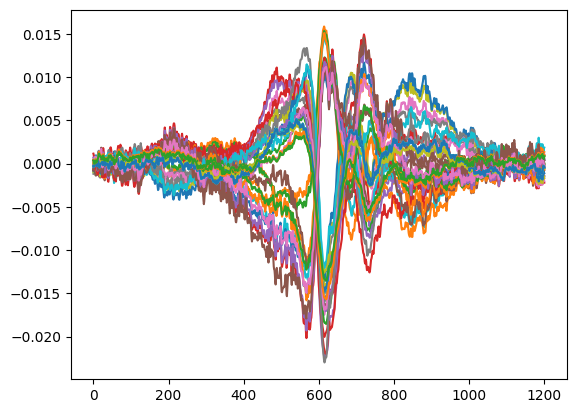

In [130]:
for i in cluster_mask:
    plt.plot(layer_ts[i])

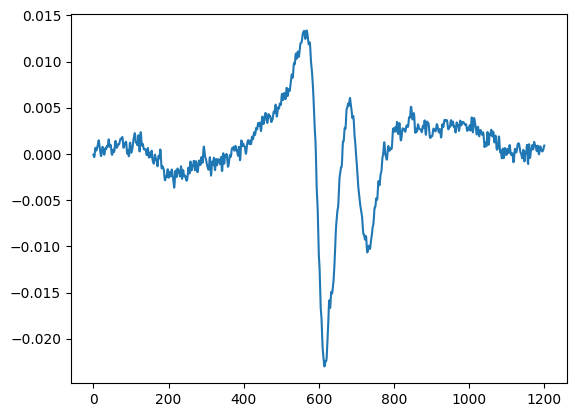

In [150]:
peak = np.argmax(m_layer_max)
plt.plot(layer_ts[peak])

In [174]:
max_verts = layer_verts[cluster_mask]

In [175]:
csd_all = []
sm_csd_all = []
for vertex in max_verts:
    start_idx = vertex * n_layers
    end_idx = start_idx + n_layers
    [csd, sm_csd] = compute_csd(
        layer_ts[start_idx:end_idx, :],
        thickness[vertex],
        s_rate,
        smoothing='cubic'
    )
    csd_all.append(csd)
    sm_csd_all.append(sm_csd)

csd_all = np.array(csd_all)
sm_csd_all = np.array(sm_csd_all)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b

In [177]:
sm_csd_all.shape

(33, 500, 1201)

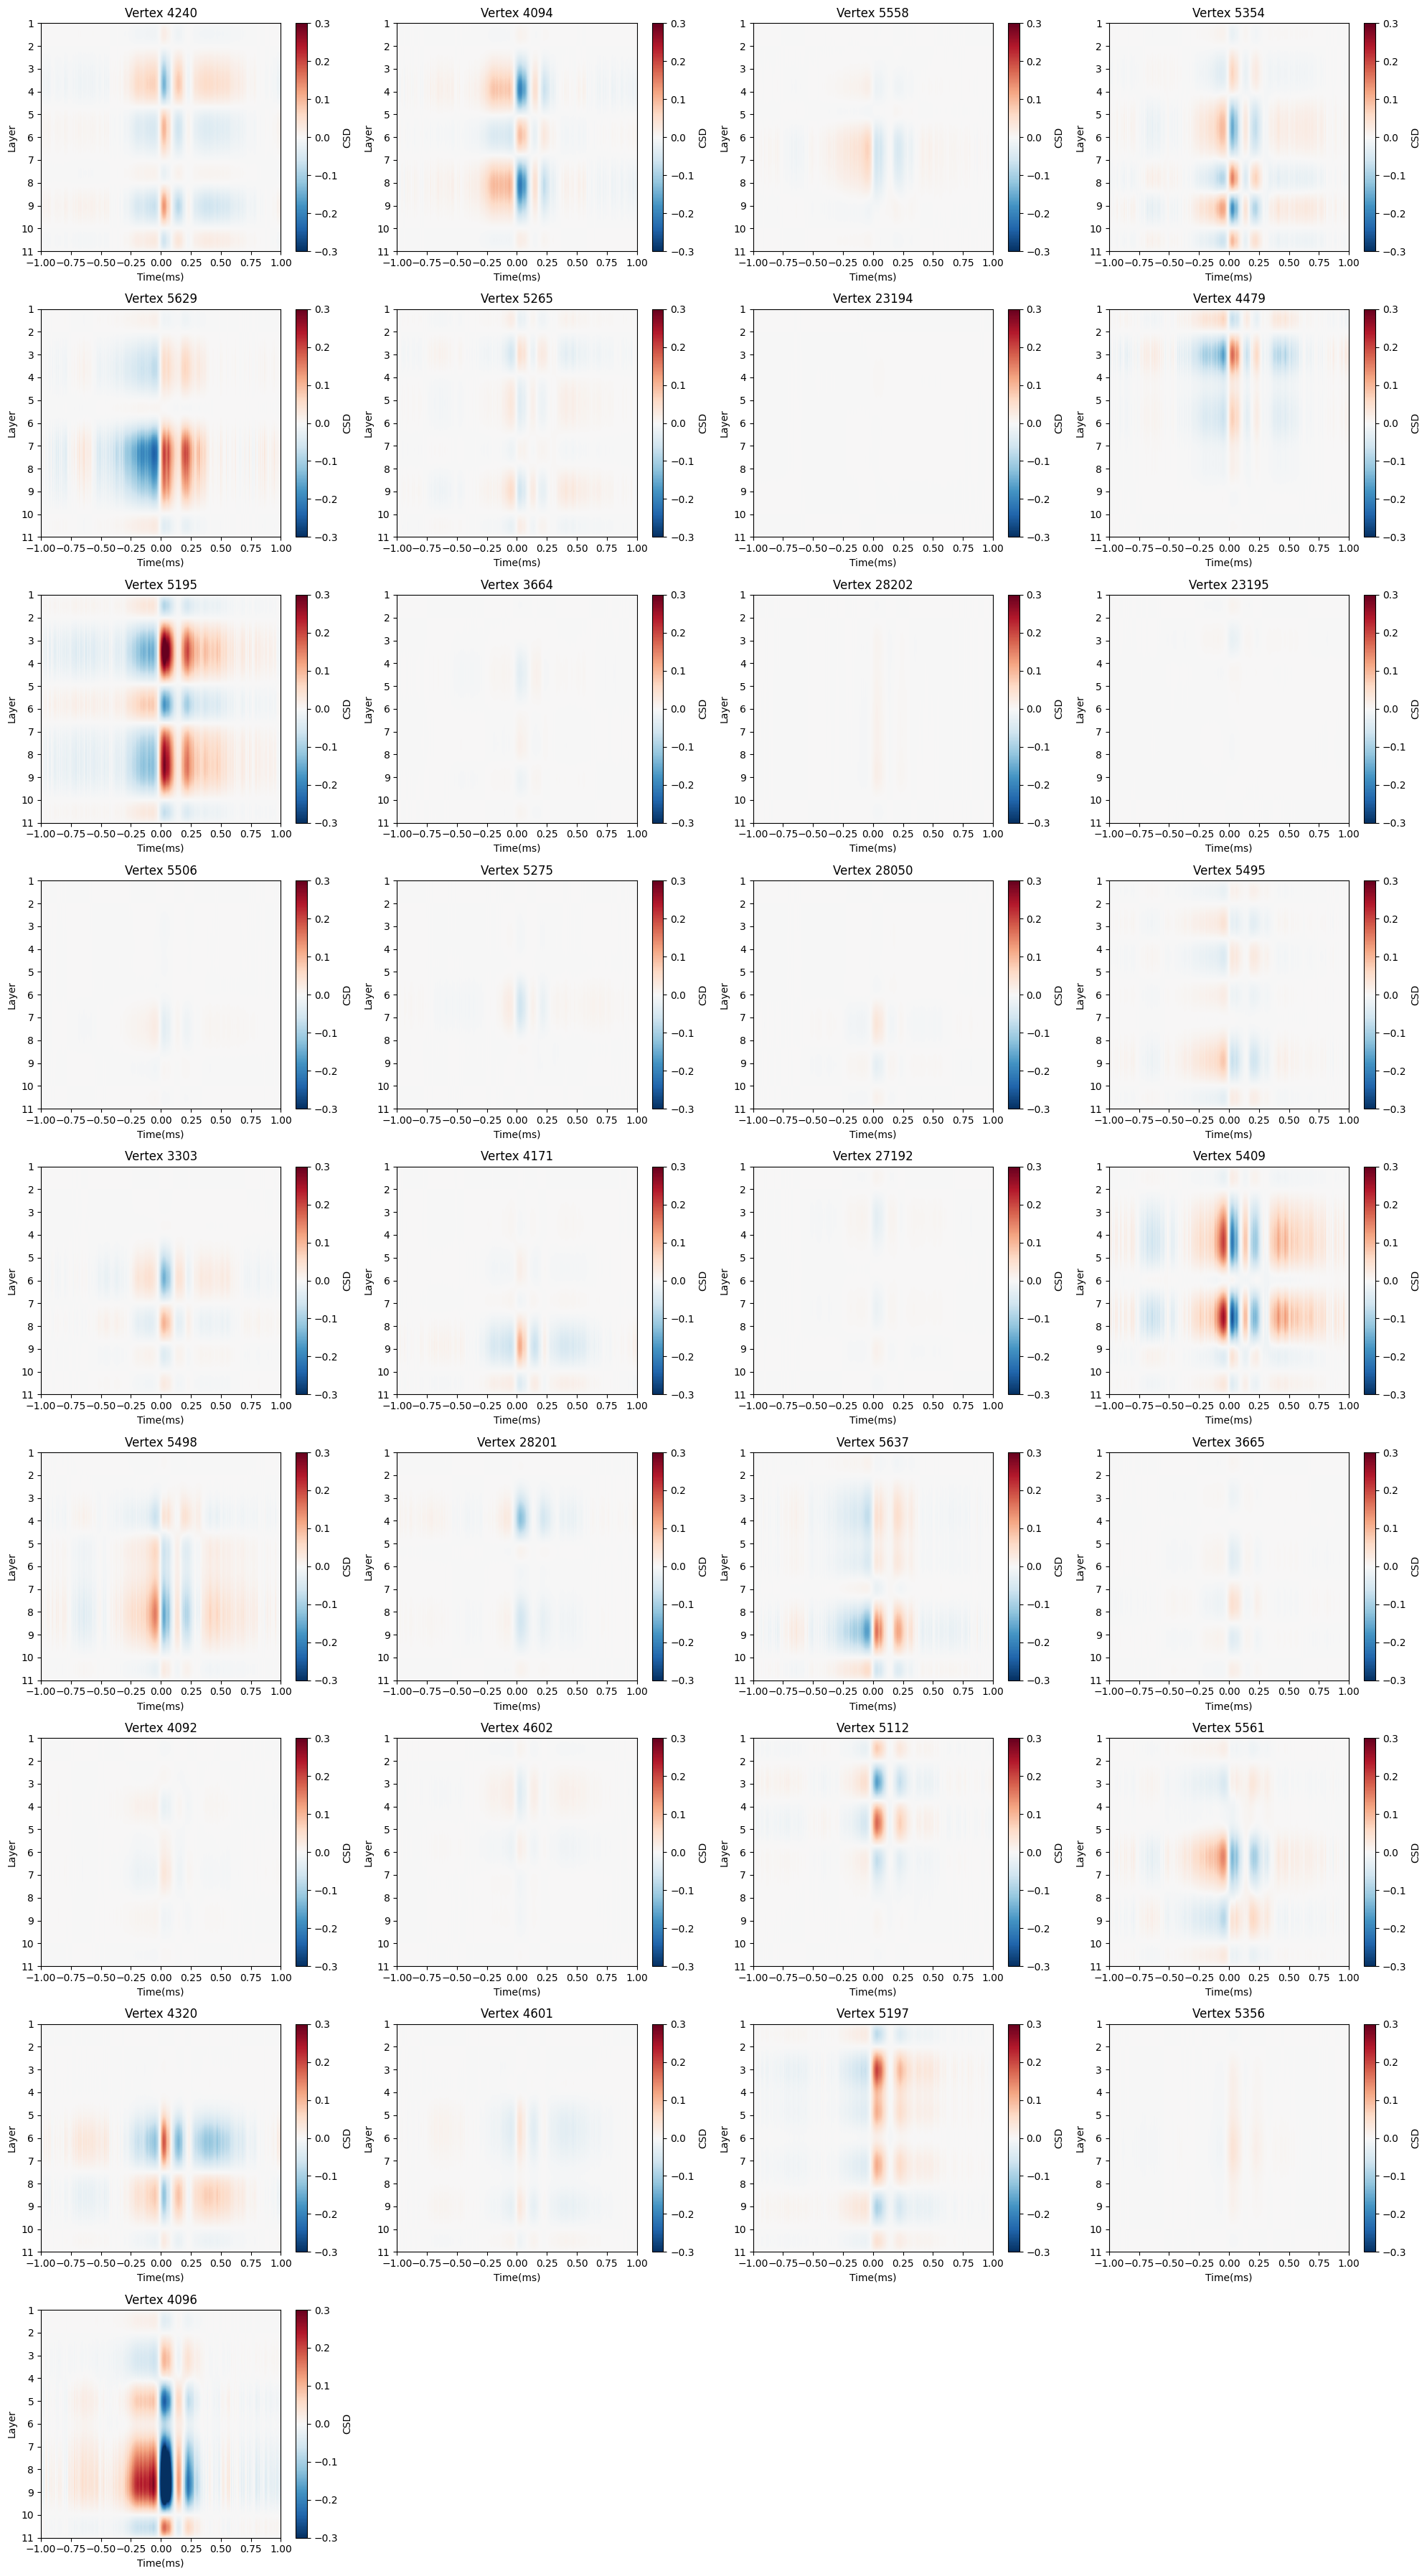

In [220]:
vmin_vmax = [-0.3,0.3]
max_plots = 33
plot_vertices = np.random.choice(len(max_verts), max_plots, replace=False) #takes random vertices

fig, axes = plt.subplots(
    nrows=int(np.ceil(max_plots / 4)),
    ncols=4,                          
    figsize=(20, 4 * int(np.ceil(max_plots / 4)))
)
axes = axes.flatten()

# plot each vertex
for i in range(max_plots):
    ax = axes[i]
    vert_ix = plot_vertices[i]
    plot_csd(sm_csd_all[vert_ix], time, ax, vmin_vmax = vmin_vmax, n_layers=n_layers)
#     for pos in bb_lb_roi[vert_ix]:
#         ax.axhline(y=pos, color='b', linestyle='-.')
    ax.set_title(f'Vertex {max_verts[vert_ix]}')
    ax.set_xlabel('Time(ms)')
    ax.set_ylabel('Layer')

# hide any unused subplots
for j in range(max_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [1]:
peak_csd_ix = np.where(max_verts == layer_verts[peak])[0]
peak_csd_ix = 5195
peak_csd_ix[0]

NameError: name 'np' is not defined

Text(0.5, 1.0, 'Vertex 5354')

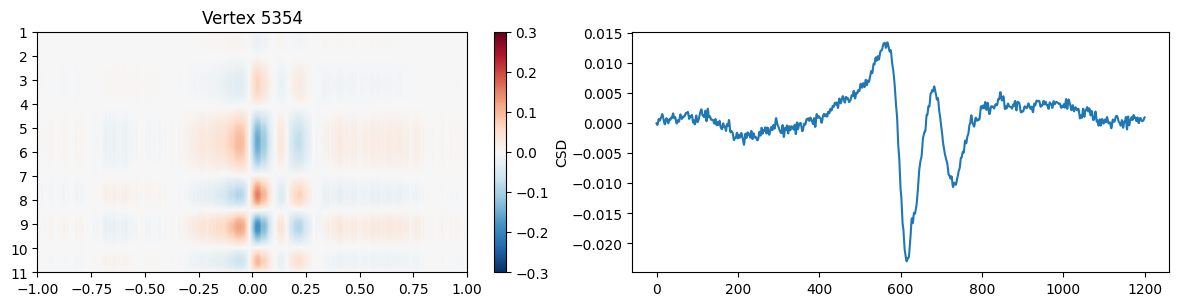

In [223]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

plot_csd(sm_csd_all[peak_csd_ix[0]], time, ax[0], vmin_vmax = vmin_vmax, n_layers=n_layers)
ax[1].plot(layer_ts[peak])
ax[0].set_title(f'Vertex {max_verts[peak_csd_ix[0]]}')

Vizualize where the maximum is

In [111]:
from lameg.surf import interpolate_data
from lameg.viz import show_surface, color_map
import io
from PIL import Image
from base64 import b64decode
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [110]:
orig_inflated_fname = os.path.join(subj_surf_dir,'inflated.gii')
ds_inflated_fname = os.path.join(subj_surf_dir,'inflated.ds.gii')

orig_inflated = nib.load(orig_inflated_fname)
ds_inflated = nib.load(ds_inflated_fname)

In [131]:
precentral_view = [-178.9392420191627,-45.354421787933546,128.49784196033622,
                   8, 2.5, -32,
                   0.7760071820687688, -0.2981949773300084, 0.5641742717218174]

In [158]:
orig_inflated.darrays[0].data

array([[ 51.64529  , -92.43684  , -83.23982  ],
       [ 51.39286  , -92.44886  , -83.2998   ],
       [ 51.62358  , -92.49616  , -83.63075  ],
       ...,
       [116.87364  , 174.7076   ,   7.31653  ],
       [115.61734  , 174.1729   ,   4.3688984],
       [115.285034 , 174.96991  ,   6.0611362]], dtype=float32)

In [167]:
cluster_coords = ds_inflated.darrays[0].data[layer_verts[cluster_mask],:]
peak_coord = ds_inflated.darrays[0].data[layer_verts[peak],:]

In [168]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)

In [248]:
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    vertex_colors=colors, 
    info=True, 
    camera_view=precentral_view, 
    coords=cluster_coords, #peak_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

Output()

317496 vertices


Extract the time and erf and write them to npy files

In [224]:
time_output_fname = os.path.join(out_dir,'time.npy')
erf_output_fname = os.path.join(out_dir, f'erf.npy')

In [246]:
np.save(time_output_fname, time*1000)
np.save(erf_output_fname, layer_ts[peak])